## **HYBRID MODEL**

In [ ]:
pip install transformers textstat nltk pandas scikit-learn tqdm

In [ ]:
import torch
import nltk
import pandas as pd
import numpy as np
import textstat
import re
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from tqdm import tqdm

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# Load GPT2 model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()

stop_words = set(stopwords.words('english'))

def get_perplexity(text):
    try:
        encodings = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
        with torch.no_grad():
            output = model(**encodings, labels=encodings['input_ids'])
        loss = output.loss
        return torch.exp(loss).item()
    except:
        return 100.0  # fallback

def extract_features(text):
    tokens = word_tokenize(text)
    pos = pos_tag(tokens)
    num_words = len(tokens)

    stop_ratio = len([w for w in tokens if w.lower() in stop_words]) / (num_words + 1)
    sent_len = len(tokens) / (text.count('.') + 1)
    reading = textstat.flesch_reading_ease(text)
    perplexity = get_perplexity(text)

    pos_tags = [tag for word, tag in pos]
    noun_ratio = pos_tags.count("NN") / (num_words + 1)
    verb_ratio = pos_tags.count("VB") / (num_words + 1)

    return [perplexity, reading, sent_len, stop_ratio, noun_ratio, verb_ratio]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [ ]:
df = pd.read_csv("sampled_ai_dataset.csv")  # or .json
features = []
labels = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    text = str(row['text'])
    label = row['generated']
    feat = extract_features(text)
    features.append(feat)
    labels.append(label)

X = np.array(features)
y = np.array(labels)

100%|██████████| 2000/2000 [1:14:40<00:00,  2.24s/it]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import joblib

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=200)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Save the trained model to a file
joblib.dump(clf, "ai_detection_model.joblib")

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       253
           1       0.96      0.90      0.93       147

    accuracy                           0.95       400
   macro avg       0.95      0.94      0.95       400
weighted avg       0.95      0.95      0.95       400



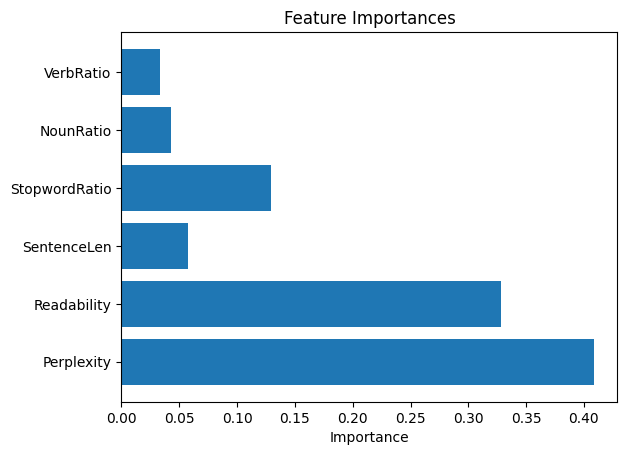

In [ ]:
import matplotlib.pyplot as plt

importances = clf.feature_importances_
labels = ['Perplexity', 'Readability', 'SentenceLen', 'StopwordRatio', 'NounRatio', 'VerbRatio']
plt.barh(labels, importances)
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.show()

In [ ]:
def predict_ai(text):
    features = extract_features(text)
    prediction = clf.predict([features])[0]
    return "AI-Generated" if prediction == 1 else "Human-Written"

In [ ]:
!pip install pyngrok

In [ ]:
from flask import Flask, request, jsonify
from pyngrok import ngrok, conf
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from dotenv import load_dotenv
import torch, textstat, re
import os
import numpy as np
import nltk

load_dotenv()

# Initialize Flask app
app = Flask(__name__)

conf.get_default().auth_token = os.getenv("NGROK_AUTH_TOKEN")

# Start ngrok tunnel
public_url = ngrok.connect(5000)
print(f" * Ngrok tunnel URL: {public_url}")

# Load model
from joblib import load
clf = load("ai_detection_model.joblib")  # Your trained model file

# Load GPT-2 and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")
gpt2_model.eval()

# Setup NLTK
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# --- Utility Functions ---

def get_perplexity(text):
    try:
        encodings = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
        with torch.no_grad():
            output = gpt2_model(**encodings, labels=encodings['input_ids'])
        return torch.exp(output.loss).item()
    except:
        return 100.0  # default high perplexity

def extract_features(text):
    tokens = word_tokenize(text)
    pos = pos_tag(tokens)
    num_words = len(tokens) + 1

    stop_ratio = len([w for w in tokens if w.lower() in stop_words]) / num_words
    sent_len = len(tokens) / (text.count('.') + 1)
    reading = textstat.flesch_reading_ease(text)
    perplexity = get_perplexity(text)

    pos_tags = [tag for word, tag in pos]
    noun_ratio = pos_tags.count("NN") / num_words
    verb_ratio = pos_tags.count("VB") / num_words

    return [perplexity, reading, sent_len, stop_ratio, noun_ratio, verb_ratio]

def split_sentences(text):
    cleaned = re.sub(r'\s+', ' ', text.strip())
    sentences = re.split(r'[.!?]', cleaned)
    return [s.strip() for s in sentences if s.strip()]

# --- Flask Routes ---

@app.route("/detect-ai/", methods=["POST"])
def detect_ai():
    data = request.get_json()
    text = data.get("text", "")
    if not text:
        return jsonify({"error": "No input text provided"}), 400

    sentences = split_sentences(text)
    ai_sentences = []

    for sentence in sentences:
        features = extract_features(sentence)
        prediction = clf.predict([features])[0]
        if prediction == 1:
            ai_sentences.append(sentence)

    percentage = round(len(ai_sentences) / len(sentences) * 100, 2) if sentences else 0.0

    return jsonify({
        "total_sentences": len(sentences),
        "ai_sentences_count": len(ai_sentences),
        "ai_percentage": percentage,
        "ai_sentences": ai_sentences
    })

# Start the Flask app
app.run()

 * Ngrok tunnel URL: NgrokTunnel: "https://bcd17353b456.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [16/Jul/2025 10:23:49] "POST /detect-ai/ HTTP/1.1" 200 -


In [ ]:
pip install google-generativeai

In [ ]:
from flask import Flask, request, jsonify
from pyngrok import ngrok, conf
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from transformers import GPT2Tokenizer, GPT2LMHeadModel, pipeline, set_seed
import google.generativeai as genai
import torch, textstat, re
import numpy as np
import os
import nltk
from joblib import load

# Initialize Flask app
app = Flask(__name__)

# Ngrok authentication
conf.get_default().auth_token = os.getenv("NGROK_AUTH_TOKEN")
public_url = ngrok.connect(5000)
print(f" * Ngrok tunnel URL: {public_url}")

# Load trained model
clf = load("ai_detection_model.joblib")

# Load GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")
gpt2_model.eval()

# Load Gemini Api key into model
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
genai.configure(api_key=GEMINI_API_KEY)

# Humanizer using text-generation model (can use gpt2 or distilgpt2)
humanizer = pipeline("text-generation", model="gpt2", tokenizer="gpt2")
set_seed(42)

# Setup NLTK
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# --- Utility Functions ---

def get_perplexity(text):
    try:
        encodings = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
        with torch.no_grad():
            output = gpt2_model(**encodings, labels=encodings['input_ids'])
        return torch.exp(output.loss).item()
    except:
        return 100.0

def extract_features(text):
    tokens = word_tokenize(text)
    pos = pos_tag(tokens)
    num_words = len(tokens) + 1
    stop_ratio = len([w for w in tokens if w.lower() in stop_words]) / num_words
    sent_len = len(tokens) / (text.count('.') + 1)
    reading = textstat.flesch_reading_ease(text)
    perplexity = get_perplexity(text)
    pos_tags = [tag for _, tag in pos]
    noun_ratio = pos_tags.count("NN") / num_words
    verb_ratio = pos_tags.count("VB") / num_words

    return [perplexity, reading, sent_len, stop_ratio, noun_ratio, verb_ratio]

def split_sentences(text):
    cleaned = re.sub(r'\s+', ' ', text.strip())
    sentences = re.split(r'[.!?]', cleaned)
    return [s.strip() for s in sentences if s.strip()]


def rewrite_sentence(sentence):
    prompt = f"Rewrite the following sentence so it sounds more natural, personal, and written by a human:\n\n\"{sentence}\""

    try:
        model = genai.GenerativeModel("gemini-pro")
        response = model.generate_content(prompt)
        rewritten = response.text.strip()

        # Basic cleanup: remove prompt echo or quotes
        if rewritten.startswith('"') and rewritten.endswith('"'):
            rewritten = rewritten[1:-1].strip()

        return rewritten if len(rewritten) > 5 else sentence
    except Exception as e:
        print(f"Rewrite error: {e}")
        return sentence


# --- API Route ---

@app.route("/check-ai/", methods=["POST"])
def detect_ai():
    data = request.get_json()
    text = data.get("text", "")
    if not text:
        return jsonify({"error": "No input text provided"}), 400

    sentences = split_sentences(text)
    ai_sentences = []
    borderline_sentences = []
    results = []

    for sentence in sentences:
        features = extract_features(sentence)
        prob = clf.predict_proba([features])[0][1]

        label = "AI-Generated" if prob >= 0.65 else "Human-Written"
        if prob >= 0.65:
            ai_sentences.append(sentence)
        elif 0.4 < prob < 0.65:
            borderline_sentences.append(sentence)

        results.append({
            "sentence": sentence,
            "ai_probability": round(prob, 2),
            "label": label
        })

    ai_percentage = round(len(ai_sentences) / len(sentences) * 100, 2) if sentences else 0.0

    return jsonify({
        "total_sentences": len(sentences),
        "ai_sentences_count": len(ai_sentences),
        "ai_percentage": ai_percentage,
        "ai_sentences": ai_sentences,
        "borderline_sentences": borderline_sentences,
        "sentence_predictions": results
    })

@app.route("/humanize/", methods=["POST"])
def humanize_text():
    data = request.get_json()
    text = data.get("text", "")
    if not text:
        return jsonify({"error": "No input text provided"}), 400

    sentences = [s.strip() for s in split_sentences(text) if s.strip()]
    ai_sentences = []
    rewritten_sentences = []

    for sentence in sentences:
        features = extract_features(sentence)
        prediction = clf.predict([features])[0]

        if prediction == 1:
            ai_sentences.append(sentence)

        rewritten = rewrite_sentence(sentence)
        rewritten_sentences.append(rewritten)

    return jsonify({
        "total_sentences": len(sentences),
        "ai_sentences_count": len(ai_sentences),
        "original_ai_sentences": ai_sentences,
        "modified_text": " ".join(s + "." for s in rewritten_sentences),
        "rewrites": [{"original": o, "rewritten": r} for o, r in zip(sentences, rewritten_sentences)]
    })

# Start the Flask app
app.run()

 * Ngrok tunnel URL: NgrokTunnel: "https://4b59339ddd95.ngrok-free.app" -> "http://localhost:5000"


Device set to use cpu
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
 * Tip: There are .env files present. Install python-dotenv to use them.


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


Rewrite error: HTTPConnectionPool(host='localhost', port=36737): Read timed out. (read timeout=600.0)
